In [17]:
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

import cv2
import os

from sklearn.model_selection import GridSearchCV
import time
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
import tensorflow as tf


from keras import layers
from keras.models import Sequential
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D,Dropout
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from IPython.display import SVG
import keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix


In [1]:
train_dir = '/kaggle/input/aslamerican-sign-language-aplhabet-dataset/ASL_Alphabet_Dataset/asl_alphabet_train/'
test_dir =  '/kaggle/input/aslamerican-sign-language-aplhabet-dataset/ASL_Alphabet_Dataset/asl_alphabet_test/'
IMG_SIZE = 28
labels_map = {'A':0,'B':1,'C': 2, 'D': 3, 'E':4,'F':5,'G':6, 'H': 7, 'I':8, 'J':9,'K':10,'L':11, 'M': 12, 'N': 13, 'O':14, 
                'P':15,'Q':16, 'R': 17, 'S': 18, 'T':19, 'U':20,'V':21, 'W': 22, 'X': 23, 'Y':24, 'Z':25, 
                'del': 26, 'nothing': 27,'space':28}


ROWS = IMG_SIZE
COLS = IMG_SIZE
CHANNELS = 3
CLASSES = 29

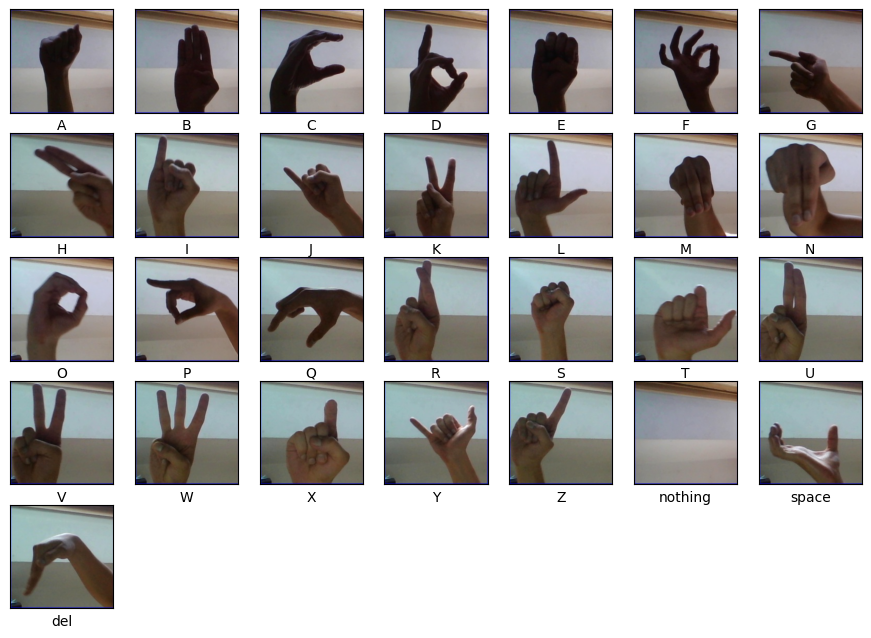

In [19]:

classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z', 'nothing', 'space', 'del']

plt.figure(figsize=(11, 11))
for i in range(0, 29):
    plt.subplot(7, 7, i + 1)
    plt.xticks([])
    plt.yticks([])
    
    path = os.path.join(train_dir, "{0}/{0}1.jpg".format(classes[i]))
    

    if os.path.exists(path):
        img = plt.imread(path)
        plt.imshow(img)
        plt.xlabel(classes[i])
    else:
        plt.text(0.5, 0.5, 'File not found', ha='center', va='center', fontsize=12)
plt.show()

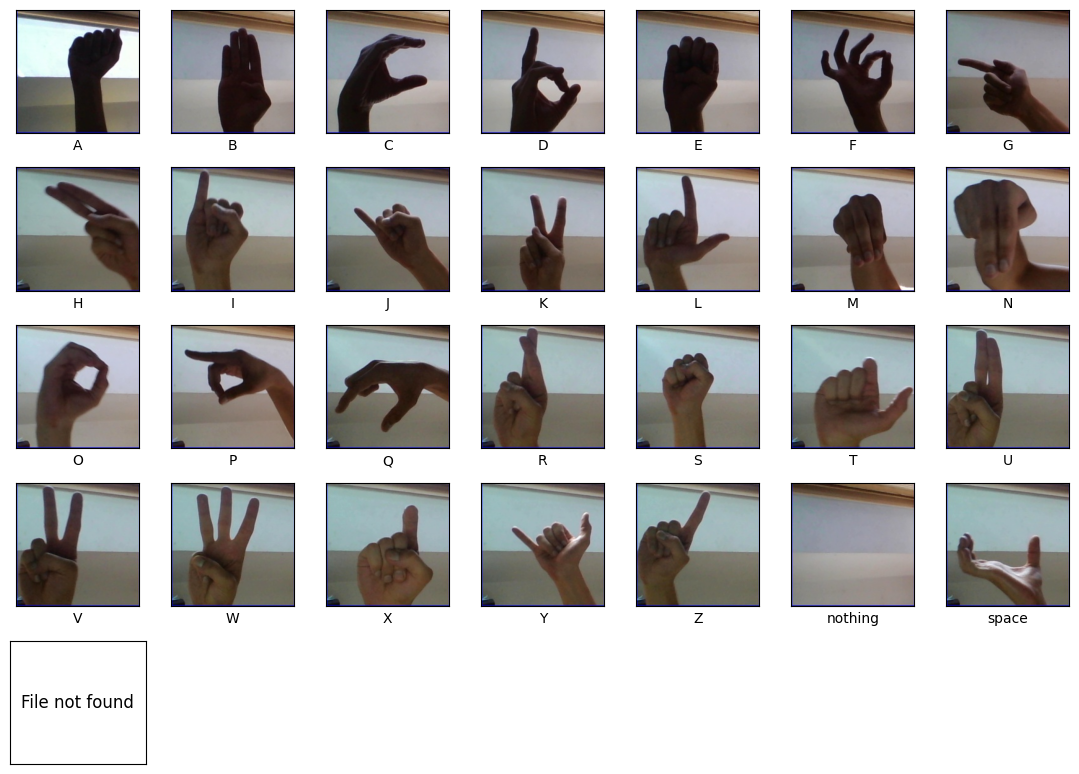

In [20]:
plt.figure(figsize=(11, 11))
for i in range(0, 29):
    plt.subplot(7, 7, i + 1)
    plt.xticks([])
    plt.yticks([])

    path = os.path.join(test_dir, "{0}_test.jpg".format(classes[i]))
    
    if os.path.exists(path):
        img = plt.imread(path)
        plt.imshow(img)
        plt.xlabel(classes[i])
    else:
        plt.text(0.5, 0.5, 'File not found', ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()

In [21]:


def create_train_data():
    x_train = []
    y_train = []
    for folder_name in os.listdir(train_dir):
        label = labels_map[folder_name]
        for image_filename in tqdm(os.listdir(train_dir + folder_name)[:m]):
            path = os.path.join(train_dir,folder_name,image_filename)
            img = cv2.resize(cv2.imread(path, cv2.IMREAD_COLOR),(IMG_SIZE, IMG_SIZE ))
            x_train.append(np.array(img))
            y_train.append(label)
    print("Done creating train data")
    return x_train, y_train

def create_test_data():
    x_test = []
    y_test = []
    for folder_name in os.listdir(train_dir):
        label = labels_map[folder_name]
        for image_filename in tqdm(os.listdir(train_dir + folder_name)[m:(2*m)]):
            path = os.path.join(train_dir,folder_name,image_filename)
            img = cv2.resize(cv2.imread(path, cv2.IMREAD_COLOR),(IMG_SIZE, IMG_SIZE ))
            x_test.append(np.array(img))
            y_test.append(label)
    print("Done creating train data")
    return x_test, y_test




In [22]:
x_train_set, y_train_set= create_train_data()  

  0%|          | 0/900 [00:00<?, ?it/s]

100%|██████████| 900/900 [00:03<00:00, 282.97it/s]

Done creating train data


In [24]:
x_test_set,y_test_set = create_test_data()

100%|██████████| 900/900 [00:03<00:00, 259.93it/s]

Done creating train data


In [25]:
y_train_arr = np.array(y_train_set)
y_train_arr = y_train_arr.reshape(1, len(y_train_arr))

y_test_arr = np.array(y_test_set)
y_test_arr = y_test_arr.reshape(1, len(y_test_arr))

print('Before encoding: ')
print('y_train_arr shape', np.shape(y_train_arr))
print('y_train_arr type', type(y_train_arr))

X_train = np.array(x_train_set)/255
X_test = np.array(x_test_set)/255

Before encoding: 
y_train_arr shape (1, 26100)
y_train_arr type <class 'numpy.ndarray'>


In [26]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [27]:
Y_train = convert_to_one_hot(y_train_arr, CLASSES).T
Y_test = convert_to_one_hot(y_test_arr, CLASSES).T

In [28]:
print ("number of training examples =", X_train.shape[0])
print ("number of test examples =", X_test.shape[0])
print ("X_train shape:", X_train.shape)
print ("Y_train shape:", Y_train.shape)
print ("X_test shape:", X_test.shape)
print ("Y_test shape:", Y_test.shape)

number of training examples = 26100
number of test examples = 26100
X_train shape: (26100, 28, 28, 3)
Y_train shape: (26100, 29)
X_test shape: (26100, 28, 28, 3)
Y_test shape: (26100, 29)


In [29]:
model_cnn = Sequential()


model_cnn.add(Conv2D(32, (3, 3), padding='same', input_shape=(28, 28, 3), kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Dropout(0.25))


model_cnn.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Dropout(0.25))

model_cnn.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Dropout(0.25))


model_cnn.add(Flatten())
model_cnn.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model_cnn.add(Dropout(0.5))


model_cnn.add(Dense(CLASSES, activation='softmax'))


model_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 29)             │         7,453 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 396,765 (1.51 MB)

 Trainable params: 396,317 (1.51 MB)

 Non-trainable params: 448 (1.75 KB)

In [30]:
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  
)
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(28, 28),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
validation_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(28, 28),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 178472 images belonging to 29 classes.
Found 44602 images belonging to 29 classes.


In [32]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)


In [33]:
model_cnn.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=64,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/50
408/408 - 89s - 217ms/step - accuracy: 0.2181 - loss: 3.1620 - val_accuracy: 0.0322 - val_loss: 5.5115 - learning_rate: 0.0010
Epoch 2/50
408/408 - 74s - 182ms/step - accuracy: 0.4655 - loss: 2.0086 - val_accuracy: 0.1644 - val_loss: 6.8046 - learning_rate: 0.0010
Epoch 3/50
408/408 - 75s - 184ms/step - accuracy: 0.5854 - loss: 1.5776 - val_accuracy: 0.2032 - val_loss: 6.1404 - learning_rate: 0.0010
Epoch 4/50
408/408 - 76s - 186ms/step - accuracy: 0.6538 - loss: 1.3560 - val_accuracy: 0.1648 - val_loss: 8.5893 - learning_rate: 0.0010
Epoch 5/50
408/408 - 89s - 217ms/step - accuracy: 0.6997 - loss: 1.2093 - val_accuracy: 0.1341 - val_loss: 7.6464 - learning_rate: 0.0010
Epoch 6/50
408/408 - 81s - 198ms/step - accuracy: 0.7287 - loss: 1.1226 - val_accuracy: 0.2326 - val_loss: 8.1699 - learning_rate: 0.0010
Epoch 7/50
408/408 - 77s - 188ms/step - accuracy: 0.7743 - loss: 0.9718 - val_accuracy: 0.2171 - val_loss: 8.9053 - learning_rate: 2.0000e-04
Epoch 8/50
408/408 - 75s - 183

In [34]:
model_cnn_metrics = pd.DataFrame(model_cnn.history.history)

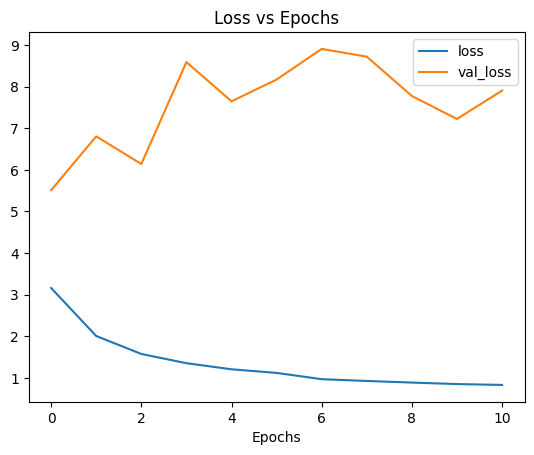

In [35]:
model_cnn_metrics[['loss','val_loss']].plot()
plt.xlabel('Epochs')
plt.title('Loss vs Epochs')
plt.show()

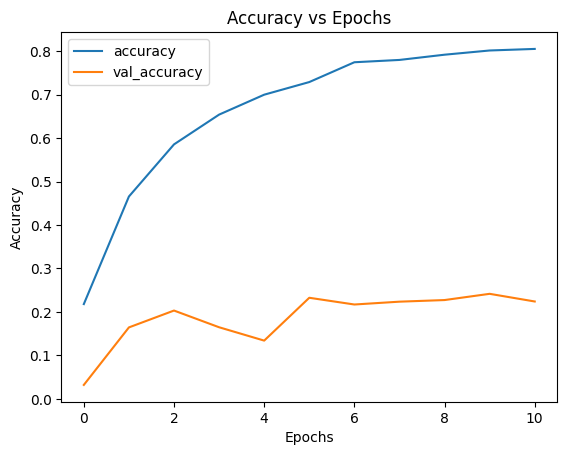

In [36]:
model_cnn_metrics[['accuracy','val_accuracy']].plot()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()

In [86]:

model_name = 'image_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model_cnn.save(model_path)
print('Save model and weights at %s ' % model_path)

model_json = model_cnn.to_json()
with open("image.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at c:\Users\Sanjay\Desktop\task2\saved_models\image_Model.h5 
